<span style="font-family:Papyrus; font-size:3em;">Lab: Cross Validation</span>


In [1]:
# Install packages within Jupyter notebook. Only need to do this once.
if False:
    !pip install numpy
    !pip install pandas
    !pip install tellurium
    !pip install matplotlib
    !pip install SBstoat
    !pip install lmfit


In [2]:
# Make the packages usable in this notebook
import numpy as np
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries, TIME
import lmfit

In [3]:
NOISE_STD = 1.5
END_TIME = 20
NUM_POINT = 100
LOWER = 0.01
UPPER = 1

# Preliminaries

In [4]:
MODEL = """
A -> B; k1*A
B -> C; k2*B
C -> D; k3*C

A = 10
B = 0
C = 0
D = 0
k1 = 0.1
k2 = 0.2
k3 = 0.3
"""

In [5]:
# Model data
PARAMETER_DCT = {
    "k1": 0.1,
    "k2": 0.2,
    "k3": 0.3,
}
PARAMETER_NAMES = list(PARAMETER_DCT.keys())
ROAD_RUNNER = te.loada(MODEL)
dataArr = ROAD_RUNNER.simulate(0, END_TIME, NUM_POINT)
FITTED_TS = NamedTimeseries(namedArray=dataArr)

In [91]:
# Generates indices of training and test data
# by alternating between folds
def foldGenerator(numPoint, numFold):
    """
    Generates pairs of trainining and test indices.
    
    Parameters:
    ----------
    numPoint: int
        number of time points
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    list of pairs of train indices, test indices
    """
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = []
        for idx in indices:
            if idx % numFold == remainder:
                testIndices.append(idx)
        trainIndices = np.array(
            list(set(indices).difference(testIndices)))
        testIndices = np.array(testIndices)
        yield trainIndices, testIndices
        
# Tests
numFold = 10
numPoint = 100
generator = foldGenerator(numPoint, numFold)
result = [(trainArr, testArr) for trainArr, testArr in generator]
assert(len(result) == numFold)
assert(isinstance(n, int) for n in result[0][0])

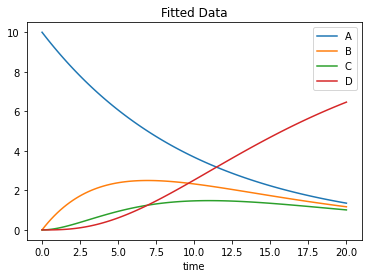

In [6]:
def plotTS(timeseries, ax=None, linetype="scatter", title=""):
    if ax is None:
        _, ax = plt.subplots(1)
    legend = []
    for col in timeseries.colnames:
        legend.append(col)
        if linetype == "scatter":
            _ = ax.scatter(timeseries[TIME], timeseries[col])
        else:
           _ = ax.plot(timeseries[TIME], timeseries[col])
    _ = ax.set_xlabel("time")
    _ = ax.set_title(title)
    _ = plt.legend(legend)
    return ax

# Tests
_ = plotTS(FITTED_TS, linetype="line", title="Fitted Data")

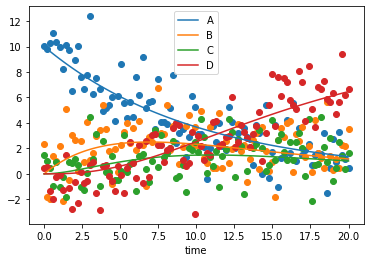

In [7]:
# Create synthetic observational data
ax = plotTS(FITTED_TS, linetype="line")
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=FITTED_TS, std=NOISE_STD)
OBSERVED_TS = synthesizer.calculate()
_ = plotTS(OBSERVED_TS, ax=ax)

# Writing a Fitter as a Class

## Basics of Python Classes

A python ``class`` is a way to *encapsulate* code so that it is more reliable and reusable by having variables
that are used exclusiely within the class.

In [8]:
# A simple class
class Simple():
    def __init__(self, a, b):
        """
        a and b are used when constructing an instance of the class.
        """
        self.a = a
        self.b = b
        self.result = None  # placeholder
    def add(self):
        """
        calculaes the sum of a and b
        """
        self.result = self.a + self. b
        return self.result

In [9]:
# Using a class
simple = Simple(3, 4)  # This calls the __init__ method, with a=3 and b=4
print(simple.add())

7


In [10]:
# You can also retrieve the result from the properties of the object
print(simple.result)

7


## Writing and Testing a Fitter Class

In [11]:
class SimpleFitter(object):

    def __init__(self, model, observedTS, parameterNames,
                lower=LOWER, upper=UPPER):
        """
        model: str (Antimony Model)
        observedTS: NamedTimeseries
        paramterNames: list-str
        lower: float
            lower range for parameter value
        upper: float
           upper range for parameter value
        """
        self.rr = te.loada(model)
        self.observedTS = observedTS.copy()
        self.parameterNames = parameterNames
        self.colnames = self.observedTS.colnames
        self.lower = lower
        self.upper = upper
        self.value = (lower + upper)/2
        self.params = None
        self.fittedTS = None
        
    def mkParams(self):
        parameters = lmfit.Parameters()
        for parameterName in self.parameterNames:
            parameters.add(parameterName,
                          min=self.lower,
                          max=self.upper,
                          value=self.value)
        return parameters
        
    def calcResiduals(self, params):
        self.rr.reset()  # Put back to time zero
        # Update the simulation parameters
        for name, value in params.valuesdict().items():
            self.rr[name] = value
        fittedArr = self.rr.simulate(0, END_TIME, NUM_POINT)
        self.fittedTS = NamedTimeseries(namedArray=fittedArr)
        fittedArr = fittedArr[:, 1:]  # Delete time column
        observedArr = self.observedTS[self.colnames]
        residualsArr = observedArr - fittedArr
        residualsArr = residualsArr.flatten()
        #print((np.sum(residuals**2), params))
        return residualsArr
    
    def fit(self, params=None, method="leastsq"):
        if params is None:
            newParams = self.mkParams()
        else:
            newParams = params.copy()
        # Find the best parameters
        minimizer = lmfit.Minimizer(self.calcResiduals, newParams)
        minimizerResult = minimizer.minimize(method=method, max_nfev=100)
        self.params = minimizerResult.params.copy()
        
# Tests
fitter = SimpleFitter(MODEL, OBSERVED_TS, PARAMETER_NAMES)
params = fitter.mkParams()
k1ParameterValue = params.valuesdict()[PARAMETER_NAMES[0]]
assert(np.isclose(k1ParameterValue, (LOWER+UPPER)/2))
#
dataArr = fitter.calcResiduals(params)
assert(np.shape(dataArr) == (NUM_POINT*4,))
#
fitter.fit()
fittedResultDct = fitter.params.valuesdict()
for parameterName, parameterValue in fittedResultDct.items():
    #print(parameterName, parameterValue)
    assert(np.abs(parameterValue - PARAMETER_DCT[parameterName]) < 0.1)

# Timestamp Alignment

## Problem description

Suppose that we have observational data that has only a subset of the timestamps of the simulation data.
How do we change ``SimpleFitter`` to accommodate this?

In [12]:

observedSubTS = OBSERVED_TS[list(range(10))]
observedSubTS

                  A         B         C         D
time                                             
0.000000  10.036201  2.379009  1.474644  0.469851
0.202020   9.828329 -1.846499  1.010448  0.569345
0.404040  10.279992 -2.014213  0.436996 -1.320193
0.606061  11.059795  1.379685 -0.976589 -1.939006
0.808081  10.362728  0.983134  0.909686 -0.244272
1.010101  10.000053  2.163480 -1.042755 -0.074025
1.212121   8.247749 -2.147068 -0.268528 -1.291519
1.414141  10.113416  5.073723 -1.835745  1.471965
1.616162   9.698746 -0.504437  0.918833 -1.135544
1.818182   6.495624  3.068281  0.821709 -2.784080

In [13]:
FITTED_TS

                   A         B         C         D
time                                              
0.000000   10.000000  0.000000  0.000000  0.000000
0.202020    9.800007  0.195994  0.003920  0.000080
0.404040    9.604013  0.380306  0.015060  0.000621
0.606061    9.411939  0.553479  0.032548  0.002034
0.808081    9.223707  0.716030  0.055585  0.004678
...              ...       ...       ...       ...
19.191919   1.467255  1.251970  1.068275  6.212500
19.393939   1.437911  1.231151  1.054123  6.276815
19.595960   1.409154  1.210581  1.039992  6.340273
19.797980   1.380971  1.190262  1.025891  6.402876
20.000000   1.353353  1.170195  1.011827  6.464625

[100 rows x 4 columns]

We want to select the indices in ``FITTED_TS`` that have times corresonding to those in obseredSubTS.

In [14]:
observedSubTimes = observedSubTS[TIME]
observedSubTimes

array([0.        , 0.2020202 , 0.4040404 , 0.60606061, 0.80808081,
       1.01010101, 1.21212121, 1.41414141, 1.61616162, 1.81818182])

In [15]:
fittedTSTimes = FITTED_TS[TIME]
fittedTSTimes

array([ 0.        ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081,
        1.01010101,  1.21212121,  1.41414141,  1.61616162,  1.81818182,
        2.02020202,  2.22222222,  2.42424242,  2.62626263,  2.82828283,
        3.03030303,  3.23232323,  3.43434343,  3.63636364,  3.83838384,
        4.04040404,  4.24242424,  4.44444444,  4.64646465,  4.84848485,
        5.05050505,  5.25252525,  5.45454545,  5.65656566,  5.85858586,
        6.06060606,  6.26262626,  6.46464646,  6.66666667,  6.86868687,
        7.07070707,  7.27272727,  7.47474747,  7.67676768,  7.87878788,
        8.08080808,  8.28282828,  8.48484848,  8.68686869,  8.88888889,
        9.09090909,  9.29292929,  9.49494949,  9.6969697 ,  9.8989899 ,
       10.1010101 , 10.3030303 , 10.50505051, 10.70707071, 10.90909091,
       11.11111111, 11.31313131, 11.51515152, 11.71717172, 11.91919192,
       12.12121212, 12.32323232, 12.52525253, 12.72727273, 12.92929293,
       13.13131313, 13.33333333, 13.53535354, 13.73737374, 13.93

In [16]:
# Here's a hint to get started. Suppose we want to find the time value in fittedTSTimes that's closest to the 4th
# value in observedSubTime. This is a kind of distance measure.
(observedSubTimes[4] - fittedTSTimes)**2

array([6.52994592e-01, 3.67309458e-01, 1.63248648e-01, 4.08121620e-02,
       0.00000000e+00, 4.08121620e-02, 1.63248648e-01, 3.67309458e-01,
       6.52994592e-01, 1.02030405e+00, 1.46923783e+00, 1.99979594e+00,
       2.61197837e+00, 3.30578512e+00, 4.08121620e+00, 4.93827160e+00,
       5.87695133e+00, 6.89725538e+00, 7.99918376e+00, 9.18273646e+00,
       1.04479135e+01, 1.17947148e+01, 1.32231405e+01, 1.47331905e+01,
       1.63248648e+01, 1.79981635e+01, 1.97530864e+01, 2.15896337e+01,
       2.35078053e+01, 2.55076013e+01, 2.75890215e+01, 2.97520661e+01,
       3.19967350e+01, 3.43230283e+01, 3.67309458e+01, 3.92204877e+01,
       4.17916539e+01, 4.44444444e+01, 4.71788593e+01, 4.99948985e+01,
       5.28925620e+01, 5.58718498e+01, 5.89327620e+01, 6.20752984e+01,
       6.52994592e+01, 6.86052444e+01, 7.19926538e+01, 7.54616876e+01,
       7.90123457e+01, 8.26446281e+01, 8.63585348e+01, 9.01540659e+01,
       9.40312213e+01, 9.79900010e+01, 1.02030405e+02, 1.06152433e+02,
      

## An Approach

That is, we want to find the index for the array element that is 0.
We can do this by sorting the indices of fittedTSTimes by their distance from designated time in observedSubTimes.

In [17]:
values = (observedSubTimes[4] - fittedTSTimes)**2
def finder(index):
    return values[index]
sorted(range(len(values)), key=finder)

[4,
 3,
 5,
 2,
 6,
 1,
 7,
 0,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [18]:
def selectCompatibleIndices(bigTimes, smallTimes):
    """
    Finds the indices such that smallTimes[n] is close to bigTimes[indices[n]]
    
    Parameters
    ----------
    bigTimes: np.ndarray
    smalltimes: np.ndarray
    
    Returns
    np.ndarray
    """
    indices = []
    for idx in range(len(smallTimes)):
        distances = (bigTimes - smallTimes[idx])**2
        def getValue(k):
            return distances[k]
        thisIndices = sorted(range(len(distances)), key=getValue)
        indices.append(thisIndices[0])
    return np.array(indices)

# Tests
indices = selectCompatibleIndices(FITTED_TS[TIME], observedSubTS[TIME])
assert(len(indices) == len(observedSubTS))
for i, index in enumerate(indices):
    assert(index == i)

## Revise the residuals calculation

The only method impacted is ``calcResiduals``.
Let's figure this out incrementally.
Start by doing the residuals calculation using ``observedSubTS`` and ``fittedArr``.

In [19]:
colnames = FITTED_TS.colnames
fittedArr = FITTED_TS[FITTED_TS.allColnames]
observedTS = observedSubTS.copy()
# Fragment of the residual calculation
#fittedArr = fittedArr[:, 1:]
indices = selectCompatibleIndices(FITTED_TS[TIME], observedTS[TIME])
observedArr = observedTS[colnames]
fittedSubArr = fittedArr[indices, 1:]
residualsArr = observedArr - fittedSubArr
residualsArr = residualsArr.flatten()

# Fitting With Timestamp Alignment

There's no assurance that the observational data have the same timestamps as the simulation data.
Solving this problem in general requires some sophistication.
For now, we will assume that the observational data contains a subset of the timestamps.

In [89]:
# Modified calcResduals
class SimpleBetterFitter(SimpleFitter):
    
    @staticmethod
    def selectCompatibleIndices(bigTimes, smallTimes):
        """
        Finds the indices such that smallTimes[n] is close to bigTimes[indices[n]]

        Parameters
        ----------
        bigTimes: np.ndarray
        smalltimes: np.ndarray

        Returns
        np.ndarray
        """
        indices = []
        for idx in range(len(smallTimes)):
            distances = (bigTimes - smallTimes[idx])**2
            def getValue(k):
                return distances[k]
            thisIndices = sorted(range(len(distances)), key=getValue)
            index = thisIndices[0]
            if isinstance(index, np.generic):
                index = np.asscalar(index)
            indices.append(index)
        return indices
        
    def calcResiduals(self, params):
        self.rr.reset()  # Put back to time zero
        # Update the simulation parameters
        for name, value in params.valuesdict().items():
            self.rr[name] = value
        fittedArr = self.rr.simulate(0, END_TIME, NUM_POINT)
        self.fittedTS = NamedTimeseries(namedArray=fittedArr)
        indices = SimpleBetterFitter.selectCompatibleIndices(fittedArr[:, 0], self.observedTS[TIME])
        fittedArr = fittedArr[indices, 1:]  # Delete time column
        observedArr = self.observedTS[self.colnames]
        residualsArr = observedArr - fittedArr
        residualsArr = residualsArr.flatten()
        return residualsArr
    
# Tests
size = 50
observedSubTS = OBSERVED_TS[list(range(size))]
fitter = SimpleBetterFitter(MODEL, observedSubTS, PARAMETER_NAMES)
fitter.fit()
assert(len(fitter.observedTS) == size)
assert(len(fitter.params.valuesdict()) == 3)

In [85]:
# Analysis of the fit quality with sample size
def analyzeQuality(numSample):
    """
    Analyzes the quality of a fit for a sample size.
    
    Parameters
    ----------
    numSample: int
    
    Returns
    -------
    float: sum of squared differences from true parameter values
    pd.DataFrame: values of true and estimated parameters
    """
    TRUE = "true"
    ESTIMATED = "estimated"
    # Select a random sample of the observational data
    length = len(OBSERVED_TS)
    randomIndices = np.random.permutation(list(range(length)))
    size = 50
    randomIndices = randomIndices[:size]
    observedSubTS = OBSERVED_TS[randomIndices.tolist()]
    # Fit the data
    fitter = SimpleBetterFitter(MODEL, observedSubTS, PARAMETER_NAMES)
    fitter.fit()
    # Evaluate the fit quality
    dct = {True: PARAMETER_DCT.values(), ESTIMATED: fitter.params.valuesdict().values()}
    df = pd.DataFrame(dct)
    df.index = PARAMETER_DCT.keys()
    trueValues = np.array(df[True])
    estimatedValues = np.array(df[ESTIMATED])
    ssqd = np.sum(trueValues-estimatedValues)**2
    return ssqd, df

# Tests
ssqd, df = analyzeQuality(100)
assert(ssqd < 0.01)
assert(len(df) == len(PARAMETER_DCT))

# Cross Validation for Simulation Models

## Pseudo Code

1. Create training and test data for the folds
1. For the training and test data
   1. Fit to training data
   1. predictedValues = Fitted values that correspond to test data
   1. Calculate $R^2$ from test data and predictedValues
1. Report the parameters and $R^2$ for each fold.

## Implementation

    # allObservedData - complete set of observed data
    
    collectionOfTrainAndTestIndices = "Generate folds"
    parametersCol = []
    rssqCol = []
    for trainIndices, testIndices in collectionOfTrainAndTestIndices
        trainData = allTrainData[trainIndices]
        allFittedData, parameters = "Fit on trainData"
        parametersCol.append(parameters)
        fittedTestValues = allFittedData[testIndices]
        observedTestValues = allObservedData[testIndices]
        rssq = 1 - variance(observedTestValues - fittedTestValues)/variance(observedTestValues)
        parameterCol.append(rssq)


In [98]:
class CrossValidator():
    
    PREDICTED = "predicted"
    TRUE = "true"
    FOLD = "fold"
    
    def __init__(self, numFold, model, observedTS, parameterNames, trueParameterDct=None, **kwargs):
        """
        numFold: int
            number of folds
        model: str (Antimony Model)
        observedTS: NamedTimeseries
        paramterNames: list-str
        trueParameterDct: dict
            key: parameter name, value: parameter value
        kwargs: dict
           optional arguments passed to fitter
        """
        self.model = model
        self.observedTS = observedTS.copy()
        self.parameterNames = parameterNames
        self.colnames = self.observedTS.colnames
        self.kwargs = kwargs
        self.trueParameterDct = trueParameterDct
        self.parametersCol = []
        self.rsqs = []

    def _calcRsq(self, observedTS, fittedTS):
        columns = observedTS.colnames
        residualsArr = observedTS[columns] - fittedTS[columns]
        rsq = 1 - np.variance(residualsArr)/np.variance(observedTS[columns])
        return rsq

    def execute(self):
        generator = foldGenerator(self.numFold, len(self.observedTS))
        for trainIndices, testIndices in generator:
            fitter = SimpleFitter(self.model, self.observedTS[trainIndices], self.parameterNames, **self.kwargs)
            fitter.fit()
            self.parametersCol.append(fitter.params.copy())
            rsq = self._calcRsq(self.observedTS[testIndices], self.fitterTS[testIndices])
            self.rsqs.append(rsq)

    def mkReportDF(self):
        if self.trueParameterDct is None:
            raise ValueError("Must specify trueParameterDct in constructor.")
        dct = {CrossValidator.FOLD: [], CrossValidator.TRUE: [], CrossValidator.ACTUAL: []}
        for fold in range(len(self.rsqs)):
            dct[FOLD].append(fold)
            dct[CrossValidator.TRUE].append(self.trueParameterDct.values())
            dct[CrossValidator.ACTUAL].append(self.parametersCol[fold].valuesdict().values())
        reportDF = pd.DataFrame(dct) 
        return reportDF